<img style="float: left; padding-right: 0px; width: 145px" src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e9/EPF_logo_2021.png/524px-EPF_logo_2021.png"> 
<br><br>


###  <div style="text-align: right">  Data Engineering - P2024 <br> <br>  <time datetime="2023-12-16">2023/12/16 </time> <br> <br> <u>Name </u>: GAUBIL Clara, RAGEOT Pierre </div>
<br> 



#   <center>  Time Series Analysis </center>


#  <center><u>  Final TSA report  : Airline Baggage Complaints </u></center>

This report will outline the steps of a time series analysis project including the seasonality/trend recognition, the exploration of decomposition tecnhiques, the recognition of a multiplicative or additive model and the forecasting methods. For that, we will use the Airline Baggage Complaints data set. 

The data set contains monthly observations from 2004 to 2010 for United Airlines, American Eagle, and Hawaiian Airlines. The variables in the data set include:

Baggage - The total number of passenger complaints for theft of baggage contents, or for lost, damaged, or misrouted luggage for the airline that month
Scheduled - The total number of flights scheduled by that airline that month
Cancelled - The total number of flights cancelled by that airline that month
Enplaned - The total number of passengers who boarded a plane with the airline that month

In [28]:
%pip install pmdarima

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                
import seaborn as sns  
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import plotly.express as px
import scipy.stats as stats
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

## <u>**1- Data exploration and cleaning**</u>

### **1-1: Load data and data cleaning**

In [30]:
# open the csv file
path = 'baggagecomplaints.csv'
df_baggage = pd.read_csv(path)

In [31]:
df_baggage.head(15)

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581
5,American Eagle,06/2004,6,2004,13684,39879,1580,1347303
6,American Eagle,07/2004,7,2004,14121,41586,1819,1396642
7,American Eagle,08/2004,8,2004,12732,42016,1465,1339264
8,American Eagle,09/2004,9,2004,7895,40871,1077,1292147
9,American Eagle,10/2004,10,2004,9444,42381,1090,1393881


In [32]:
df_baggage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    252 non-null    object
 1   Date       252 non-null    object
 2   Month      252 non-null    int64 
 3   Year       252 non-null    int64 
 4   Baggage    252 non-null    int64 
 5   Scheduled  252 non-null    int64 
 6   Cancelled  252 non-null    int64 
 7   Enplaned   252 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.9+ KB


The dates are not a the right format. We need to convert them to datetime format for easier analysis.

In [33]:
df_baggage['Date'] = pd.to_datetime(df_baggage['Date'])

<ipython-input-33-abde81cfd1f6>:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In this notebook we will focus only on the baggages complaints so we will drop all other features to have a clean dataset

In [34]:
df_baggage.drop(columns=['Scheduled', 'Cancelled', 'Enplaned'], inplace=True)
df_baggage.head(15)

,Airline,Date,Month,Year,Baggage
0,American Eagle,2004-01-01,1,2004,12502
1,American Eagle,2004-02-01,2,2004,8977
2,American Eagle,2004-03-01,3,2004,10289
3,American Eagle,2004-04-01,4,2004,8095
4,American Eagle,2004-05-01,5,2004,10618
5,American Eagle,2004-06-01,6,2004,13684
6,American Eagle,2004-07-01,7,2004,14121
7,American Eagle,2004-08-01,8,2004,12732
8,American Eagle,2004-09-01,9,2004,7895
9,American Eagle,2004-10-01,10,2004,9444


In [35]:
df_baggage.describe()

,Date,Month,Year,Baggage
count,252,252.000000,252.00000,252.000000
mean,2007-06-16 21:08:34.285714176,6.500000,2007.00000,12613.507937
min,2004-01-01 00:00:00,1.000000,2004.00000,1033.000000
25%,2005-09-23 12:00:00,3.750000,2005.00000,1910.500000
50%,2007-06-16 00:00:00,6.500000,2007.00000,12224.000000
75%,2009-03-08 18:00:00,9.250000,2009.00000,19359.250000
max,2010-12-01 00:00:00,12.000000,2010.00000,41787.000000
std,NaN,3.458922,2.00398,9993.307166


We need to modifiy the date column to have it in a more usable format:

In [36]:
df_baggage['Airline'].value_counts()

Airline
American Eagle    84
Hawaiian          84
United            84
Name: count, dtype: int64

Each airline has 84 observations, there are no duplicates in dataset or missing values.

### **1-2: first observations, analysis**  

In this part we will have a first look at the dataset distribution and see if we can "visually" (without statistical analysis) recognize trend/seasonality or deduce if the model is eather additive of multiplicative

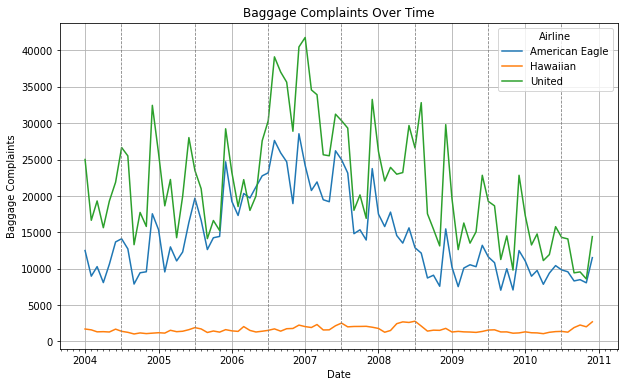

In [37]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Baggage', hue='Airline', data=df_baggage)

# Set locator for x-axis ticks (showing only years, adjust as needed)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_minor_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Midpoint of each year
for year in df_baggage['Date'].dt.year.unique():
    mid_date = pd.to_datetime(f'{year}-06-30') 
    plt.axvline(mid_date, linestyle='--', color='grey', linewidth=0.8)

plt.title('Baggage Complaints Over Time')
plt.xlabel('Date')
plt.ylabel('Baggage Complaints')
plt.grid(True)
plt.show()


After a first visualization of the data, it seems that we have a seasonality in the data related to American Eagle and Hawaiian airlines. Indeed, for these two airlines, baggage complaints seem to first decrease, then increase a little, then decrease a little, then increase a lot over a period of about half a year. The time series for Hawaiian passengers is relatively flat compared to American Eagle and United, so it’s difficult to detect a pattern over time.  

Concerning the trends, the one of the Hawaiian airline is flat, whereas we can see that trends in baggage complaints for the other two companies seem to be more difficult to analyze from these charts because of the many fluctuations. 

Finally, it seems difficullt to analyse the lines connecting the lowest points and the highest points of each curves to deduce the decomposition model (additive or multiplicative)

## <u>**2- Saisonality:**</u>

Let's dig more into the seasonality recognition with useful tools as the Buys-Ballot table and the fisher test. We will first zoom on some period to try deducing some seasonality.

### **2-1: visual exploration of seasonality** 

As the time series for hawaiaan airline is relatively flat, it is difficult to detect a pattern over time. In this way, we will display the curves separately for each airline and try to analyze the seasonality of the data.

In [38]:
fig = px.line(df_baggage, y="Baggage", x = 'Date',color="Airline", facet_col="Airline", color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(
    mirror=True,
    ticks=None,
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='',
    matches=None,
    visible=False
)
fig.show()

In [39]:
df_baggage['Year-Month'] = df_baggage['Year'].astype(str) + '-' + df_baggage['Month'].astype(str)

fig = px.line(df_baggage, y="Baggage", x='Month', color="Airline", facet_col="Airline", 
              line_group="Year", color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(plot_bgcolor='white')

fig.update_yaxes(
    mirror=True,
    ticks=None,
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='',
    matches=None,
    visible=False
)

fig.update_xaxes(
    dtick=1
)

fig.show()


By focusing separately on the 3 airlines, we better observe the time series data of the Hawaiian airline. Nevertheless, the fluctuations are importants and it is still difficult to detect a pattern over time. The above graph shows the data repartition over the months for each airline company and for each year (a single curve = a year). Again, it is difficult to detect a pattern but still it seems easier to detect some for the United Airline. Indeed, we can distinguish a drop in the number of baggage complaints followed by a small increase, a small drop followed by a large increase, and this happens a second time every year.  

We will further explore this in the next cells by studying the Buys-Ballot table and by applying a fisher test.

### **2-2: Buys-Ballot table**

The Buys-Ballot table is a statistical method that is used to determine if a time series is seasonal. We will use it to detect the seasonal variations in our dataset. In a first time, we will explore the buys ballot with periods corresponding to months.

In [40]:
airlines = df_baggage['Airline'].unique()

BBT_Hawaiian = pd.DataFrame()
BBT_Eagle = pd.DataFrame()
BBT_United = pd.DataFrame()

for airline in airlines:
    df_airline = df_baggage[df_baggage['Airline'] == airline]

    # Create a Buys-Ballot table
    buys_ballot_table = pd.pivot_table(df_airline, values='Baggage', index='Year', columns='Month', aggfunc='sum')

    # columns for mean and std for each month
    buys_ballot_table['Mean'] = buys_ballot_table.mean(axis=1)
    buys_ballot_table['Std'] = buys_ballot_table.std(axis=1)

    # rows for mean and std for each month
    buys_ballot_table.loc['Mean'] = buys_ballot_table.mean(axis=0)
    buys_ballot_table.loc['Std'] = buys_ballot_table.std(axis=0)

    # Assign the Buys-Ballot table to the corresponding airline DataFrame
    if airline == 'Hawaiian':
        BBT_Hawaiian = buys_ballot_table
    elif airline == 'American Eagle':
        BBT_Eagle = buys_ballot_table
    elif airline == 'United':
        BBT_United = buys_ballot_table

In [41]:
print("Buys-Ballot table of the United airline:")
display(BBT_United)


Buys-Ballot table of the United airline:


Month,1,2,3,4,5,6,7,8,9,10,11,12,Mean,Std
Year,,,,,,,,,,,,,,
2004,25015.000000,16660.000000,19318.000000,15638.000000,19302.000000,21892.000000,26666.000000,25510.000000,13305.000000,17736.000000,15812.000000,32458.000000,20776.000000,5401.575650
2005,25861.000000,18647.000000,22264.000000,14262.000000,19977.000000,28024.000000,23513.000000,21000.000000,14138.000000,16628.000000,15254.000000,29235.000000,20733.583333,4992.026800
2006,23232.000000,18551.000000,22246.000000,18019.000000,19996.000000,27588.000000,30325.000000,39123.000000,37039.000000,35640.000000,28896.000000,40483.000000,28428.166667,7813.493252
2007,41787.000000,34581.000000,33920.000000,25667.000000,25524.000000,31242.000000,30356.000000,29331.000000,18033.000000,20147.000000,16927.000000,33269.000000,28398.666667,7114.075383
2008,26113.000000,22059.000000,23932.000000,22994.000000,23217.000000,29690.000000,26604.000000,32827.000000,17551.000000,15429.000000,13138.000000,29803.000000,23613.083333,5714.367017
2009,19653.000000,12627.000000,16285.000000,13517.000000,15083.000000,22844.000000,19259.000000,18646.000000,11270.000000,14513.000000,9814.000000,22845.000000,16363.000000,4127.096800
2010,17307.000000,13269.000000,14782.000000,11121.000000,11947.000000,15784.000000,14309.000000,14099.000000,9435.000000,9565.000000,8597.000000,14415.000000,12885.833333,2627.581234
Mean,25566.857143,19484.857143,21821.000000,17316.857143,19292.285714,25294.857143,24433.142857,25790.857143,17253.000000,18522.571429,15491.142857,28929.714286,21599.761905,5398.602305
Std,7294.154968,6863.367945,5827.016169,4890.604912,4257.314637,5006.211211,5472.126446,8022.874893,8572.300425,7613.316883,6178.389814,7684.056940,5367.770968,1618.414128


In [42]:
print("Buys-Ballot table of the American Eagle airline:")
display(BBT_Eagle)

Buys-Ballot table of the American Eagle airline:


Month,1,2,3,4,5,6,7,8,9,10,11,12,Mean,Std
Year,,,,,,,,,,,,,,
2004,12502.000000,8977.000000,10289.000000,8095.000000,10618.000000,13684.000000,14121.000000,12732.000000,7895.000000,9444.000000,9582.000000,17555.000000,11291.166667,2759.935049
2005,15361.000000,9561.000000,13002.000000,11071.000000,12300.000000,16373.000000,19701.000000,16666.000000,12636.000000,14258.000000,14440.000000,24696.000000,15005.416667,3912.127479
2006,19255.000000,17319.000000,20344.000000,19726.000000,21248.000000,22767.000000,23184.000000,27630.000000,25922.000000,24699.000000,18954.000000,28556.000000,22467.000000,3463.158674
2007,24190.000000,20753.000000,21928.000000,19483.000000,19209.000000,26213.000000,24993.000000,23156.000000,14816.000000,15351.000000,13946.000000,23762.000000,20650.000000,3983.775784
2008,17507.000000,15795.000000,17782.000000,14566.000000,13522.000000,15620.000000,12885.000000,12148.000000,8729.000000,9110.000000,7591.000000,15475.000000,13394.166667,3268.702669
2009,10231.000000,7538.000000,10093.000000,10547.000000,10279.000000,13220.000000,11625.000000,10832.000000,7052.000000,10000.000000,7081.000000,12496.000000,10082.833333,1905.271146
2010,11059.000000,8973.000000,9762.000000,7864.000000,9399.000000,10431.000000,9840.000000,9583.000000,8324.000000,8498.000000,8067.000000,11526.000000,9443.833333,1116.545628
Mean,15729.285714,12702.285714,14742.857143,13050.285714,13796.428571,16901.142857,16621.285714,16106.714286,12196.285714,13051.428571,11380.142857,19152.285714,14619.202381,2915.645204
Std,4625.524487,4781.150212,4803.763478,4627.229832,4291.994969,5193.440848,5526.551824,6327.185308,6180.994897,5358.612450,4146.601480,6082.201216,4751.649819,988.517007


In [43]:
print("Buys-Ballot table of the Hawaiian airline:")
display(BBT_Hawaiian)

Buys-Ballot table of the Hawaiian airline:


Month,1,2,3,4,5,6,7,8,9,10,11,12,Mean,Std
Year,,,,,,,,,,,,,,
2004,1717.000000,1599.000000,1327.000000,1350.000000,1304.000000,1697.000000,1398.000000,1259.000000,1033.000000,1176.000000,1084.000000,1146.000000,1340.833333,218.414298
2005,1206.000000,1154.000000,1541.000000,1348.000000,1408.000000,1625.000000,1906.000000,1726.000000,1236.000000,1443.000000,1286.000000,1629.000000,1459.000000,221.010558
2006,1461.000000,1388.000000,2049.000000,1522.000000,1305.000000,1411.000000,1530.000000,1733.000000,1421.000000,1757.000000,1790.000000,2252.000000,1634.916667,276.970052
2007,2046.000000,1922.000000,2331.000000,1583.000000,1601.000000,2163.000000,2529.000000,2013.000000,2064.000000,2069.000000,2086.000000,1962.000000,2030.750000,252.286254
2008,1795.000000,1273.000000,1511.000000,2449.000000,2696.000000,2618.000000,2791.000000,2121.000000,1428.000000,1556.000000,1532.000000,1803.000000,1964.416667,523.203029
2009,1303.000000,1389.000000,1323.000000,1300.000000,1251.000000,1381.000000,1573.000000,1604.000000,1313.000000,1319.000000,1140.000000,1179.000000,1339.583333,131.128092
2010,1326.000000,1200.000000,1180.000000,1076.000000,1264.000000,1360.000000,1386.000000,1283.000000,1912.000000,2265.000000,2020.000000,2705.000000,1581.416667,494.611204
Mean,1550.571429,1417.857143,1608.857143,1518.285714,1547.000000,1750.714286,1873.285714,1677.000000,1486.714286,1655.000000,1562.571429,1810.857143,1621.559524,302.517641
Std,285.699571,246.913188,391.785812,409.008108,482.220459,438.439673,527.066197,304.925752,342.424847,368.584551,381.718991,519.801453,259.538352,137.253157


-> The mean column represent the average periodic value of the time series.  
-> The mean row represent the average number of baggage complaints for each months across all years.  
-> The "Std" row and column indicate the standard deviation, which measures the amount of variation or dispersion from the mean.  

We can see that 2 patterns recur throughout the year. Indeed, the number of baggage complaints seems to be high in January, then drops in February before rising a little in March and then dropping again in April. Then, between April-June or April-July, the number of baggage complaints increases before reaching a peak. The same pattern is repeated over the other half of the year (a lot of complaints, then less, then a little more, then a little less, then a lot). This could make sense, as the peaks in baggage complaints seem to be during the summer or at the end of the year, which could also correspond to the periods when airlines have the most passengers.  

In this way, the Buys Ballot table with monthly periods reveals intriguing insights into the seasonality of baggage complaints. Across the months, distinct patterns emerge, showcasing a regular ebb and flow in the number of complaints. Notably, there is a conspicuous surge in baggage complaints during January, followed by a decline in February, a modest rise in March, and another dip in April. This cyclic behavior repeats in both halves of the year, forming a distinctive seasonal rhythm. Moreover, the data suggests that specific periods, potentially corresponding to summer or year-end travel peaks, experience higher concentrations of baggage complaints. The standard deviation values accentuate the variability in certain months, emphasizing the unpredictability and fluctuation in baggage complaint numbers during these periods. 

### **2-3: fisher test**

Now, we will conduct a fisher test in order to determine whether the data have an influence on the seasonality or not.

In [44]:
def fisher_test(buys_ballot_table):
    # Extract the standard deviation values for each month
    std_values = buys_ballot_table.loc['Std'][:-1].values

    # Calculate the mean standard deviation
    mean_std = std_values.mean()

    # Calculate the Fisher test statistic
    f_statistic = (mean_std**2) / (std_values**2).mean()

    # Calculate the p-value for the Fisher test
    p_value = stats.f.cdf(f_statistic, len(std_values)-1, len(std_values)*(len(buys_ballot_table)-2))

    return f_statistic, p_value

# Perform Fisher test for each airline
f_statistic_hawaiian, p_value_hawaiian = fisher_test(BBT_Hawaiian)
f_statistic_eagle, p_value_eagle = fisher_test(BBT_Eagle)
f_statistic_united, p_value_united = fisher_test(BBT_United)

alpha = 0.05

# Print the results
print("Hawaiian Airlines - Fisher Test:")
print(f"Fisher Test Statistic: {f_statistic_hawaiian}")
print(f"P-value: {p_value_hawaiian}")
if p_value_hawaiian < alpha:
    print("Reject the null hypothesis: Seasonality is present.")
else:
    print("Fail to reject the null hypothesis: Seasonality is not significant.\n")

print("American Eagle Airlines - Fisher Test:")
print(f"Fisher Test Statistic: {f_statistic_eagle}")
print(f"P-value: {p_value_eagle}")
if p_value_eagle < alpha:
    print("Reject the null hypothesis: Seasonality is present.")
else:
    print("Fail to reject the null hypothesis: Seasonality is not significant.\n")

print("United Airlines - Fisher Test:")
print(f"Fisher Test Statistic: {f_statistic_united}")
print(f"P-value: {p_value_united}")
if p_value_united < alpha:
    print("Reject the null hypothesis: Seasonality is present.")
else:
    print("Fail to reject the null hypothesis: Seasonality is not significant.\n")




Hawaiian Airlines - Fisher Test:
Fisher Test Statistic: 0.9477323293646116
P-value: 0.49593950530465497
Fail to reject the null hypothesis: Seasonality is not significant.

American Eagle Airlines - Fisher Test:
Fisher Test Statistic: 0.9821871262642465
P-value: 0.5281630359476059
Fail to reject the null hypothesis: Seasonality is not significant.

United Airlines - Fisher Test:
Fisher Test Statistic: 0.9591401576509307
P-value: 0.5067112195222129
Fail to reject the null hypothesis: Seasonality is not significant.



As we conduct a fisher test, our hypothesis are the following:
- H0: no association between the seasonality and the data, data don't influence the seasonality
- H1: there is an association between the seasonality and the data, data influence the seasonality  

Based on the results of Fisher's test, we can deduce that the time series given has no influence on seasonality. In other words, based on the Fisher tests, there is no strong indication enoought that the variability across seasons is significantly different. The fisher test shows that the data does not show a consistent and statistically significant pattern that repeats across seasons.

## <u>**3- Trend:**</u>

The idea now is to visualize the trend of our data. Firstly, we will analyze the "raw" data with linear regression method then we will apply a rolling window in order to smooth the data.

### 6 Years period - All Buys Ballot table 

***Without rolling window***

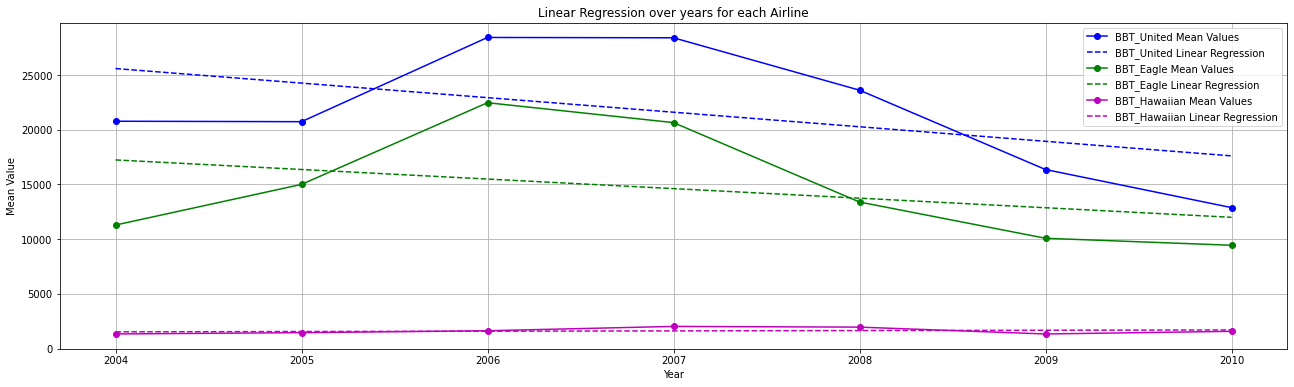

In [45]:
tables = [BBT_United, BBT_Eagle, BBT_Hawaiian]
colors = ['b', 'g', 'm']  
labels = ['BBT_United', 'BBT_Eagle', 'BBT_Hawaiian']  

plt.figure(figsize=(22, 6))

for df, color, label in zip(tables, colors, labels):
    years = pd.to_numeric(df.index[:-2], errors='coerce')  
    mean_values = df['Mean'][:-2].values

    # Original data
    plt.plot(years, mean_values, marker='o', linestyle='-', color=color, label=f'{label} Mean Values')

    # Perform linear regression
    coefficients = np.polyfit(years, mean_values, 1)
    polynomial = np.poly1d(coefficients)
    regression_line = polynomial(years)

    # Regression line plot
    plt.plot(years, regression_line, linestyle='--', color=color, label=f'{label} Linear Regression')

plt.title('Linear Regression over years for each Airline')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.show()

***With rolling window*** 

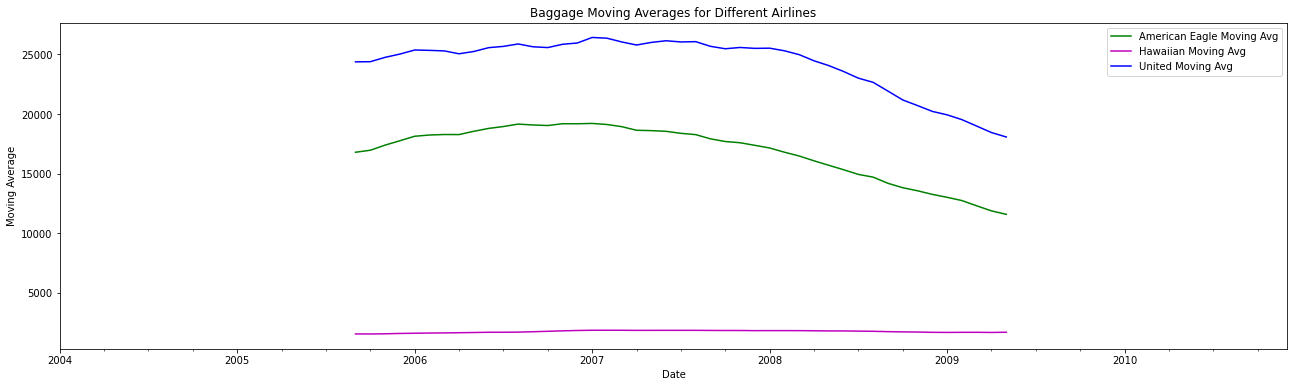

In [46]:
# Group by Airline and create separate DataFrames
grouped_airlines = df_baggage.groupby('Airline')

airline_dfs = {}
for airline, group in grouped_airlines:
    airline_dfs[airline] = group[['Date', 'Baggage']]

for airline, df in airline_dfs.items():
    df.set_index('Date', inplace=True)

plt.figure(figsize=(22, 6))

colors = {'American Eagle': 'green', 'Hawaiian': 'm', 'United': 'blue'}

for airline, df in airline_dfs.items():
    moving_avg = df['Baggage'].rolling(window=40, center=True).mean()
    moving_avg.plot(label=f'{airline} Moving Avg', color=colors[airline])

plt.legend()
plt.title('Baggage Moving Averages for Different Airlines')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.show()

The conclusion that can be drawn is that there is a general trend in the "raw" data of United and American Eagle airlines, as the number of abandoned baggage complaints seems to be decreasing (although it did increase between 2004/2005 and 2007). 

## <u>**4- Additive or Multiplicative model:**</u>

In this part, we will study the correlation between the mean and the standard deviation of our data.  
If theses two are not correlated, then our model is additive. Moreover, if the variability of the time series remains relatively constant across different levels of the mean, it suggests an additive relationship.  
Otherwise, if the variability of the time series increases or decreases with the level of the mean, it suggests a multiplicative relationship.

In [47]:
airlines = [BBT_Eagle, BBT_United, BBT_Hawaiian]

for airline in airlines:
    correlation = airline["Std"].corr(airline["Mean"])
    print(correlation)

0.8434205427475312
0.9842893442057311
0.5775387596547747


The correlation factor is near to 1 for the the American Eagles and United Airlines, it indicates that the model seems multiplicative with the following form : **𝑋𝑡 = 𝑇𝑡 ∗ 𝑆𝑡 ∗ 𝑅𝑡**.  

MSE for American Eagle: 7721446.788387347
MSE for United: 25542732.576919366


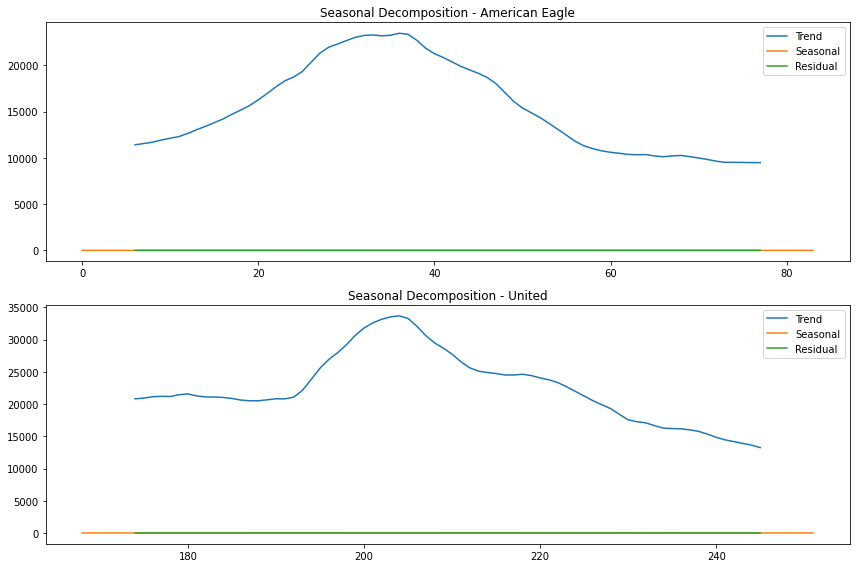

In [51]:
# Decompose the time series for American Eagle
result_ae2 = seasonal_decompose(df_baggage[df_baggage['Airline'] == 'American Eagle']['Baggage'], model='multiplicative', period=12)
trend_ae2 = result_ae2.trend.dropna()

# Decompose the time series for United
result_united2 = seasonal_decompose(df_baggage[df_baggage['Airline'] == 'United']['Baggage'], model='multiplicative', period=12)
trend_united2 = result_united2.trend.dropna()

# Calculate MSE for American Eagle
mse_ae2 = ((df_baggage[df_baggage['Airline'] == 'American Eagle']['Baggage'].loc[trend_ae2.index] - trend_ae2) ** 2).mean()

# Calculate MSE for United
mse_united2 = ((df_baggage[df_baggage['Airline'] == 'United']['Baggage'].loc[trend_united2.index] - trend_united2) ** 2).mean()

print("MSE for American Eagle:", mse_ae2)
print("MSE for United:", mse_united2)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title('Seasonal Decomposition - American Eagle')
result_ae2.trend.plot(label='Trend')
result_ae2.seasonal.plot(label='Seasonal')
result_ae2.resid.plot(label='Residual')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Seasonal Decomposition - United')
result_united2.trend.plot(label='Trend')
result_united2.seasonal.plot(label='Seasonal')
result_united2.resid.plot(label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


Despite our conclusions on the non-significant seasonality and the multiplicative model, if we compute and plot the result of an additive model with the seasonal_decompose method, there is a seasonality.  
However, we saw that there is a correlation between the mean and the standard deviation in our data.  
Here is the result with the additive model : 

MSE for American Eagle: 7721446.788387347
MSE for United: 25542732.576919366


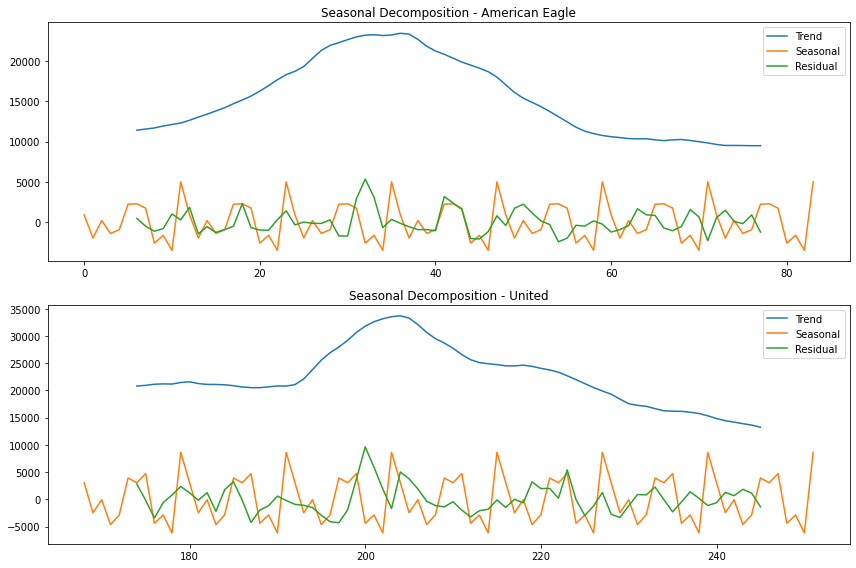

In [52]:
# Decompose the time series for American Eagle
result_ae2 = seasonal_decompose(df_baggage[df_baggage['Airline'] == 'American Eagle']['Baggage'], model='additive', period=12)
trend_ae2 = result_ae2.trend.dropna()

# Decompose the time series for United
result_united2 = seasonal_decompose(df_baggage[df_baggage['Airline'] == 'United']['Baggage'], model='additive', period=12)
trend_united2 = result_united2.trend.dropna()

# Calculate MSE for American Eagle
mse_ae2 = ((df_baggage[df_baggage['Airline'] == 'American Eagle']['Baggage'].loc[trend_ae2.index] - trend_ae2) ** 2).mean()

# Calculate MSE for United
mse_united2 = ((df_baggage[df_baggage['Airline'] == 'United']['Baggage'].loc[trend_united2.index] - trend_united2) ** 2).mean()

print("MSE for American Eagle:", mse_ae2)
print("MSE for United:", mse_united2)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.title('Seasonal Decomposition - American Eagle')
result_ae2.trend.plot(label='Trend')
result_ae2.seasonal.plot(label='Seasonal')
result_ae2.resid.plot(label='Residual')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Seasonal Decomposition - United')
result_united2.trend.plot(label='Trend')
result_united2.seasonal.plot(label='Seasonal')
result_united2.resid.plot(label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


# <u>5- Forecast: </u>

Finally, let's predict some values for the future. We will use the ARIMA model. The ARIMA model (AutoRegressive and Integrated Moving Average Models) combines 3 models in one: Autoregression models, Autoregressive models and Moving Average models. It allows the model to caputure the key components of the of a time serie including seasonality, trend and noise. 

Thus, theARIMA modele requires 3 parameters:
- **p (Autoregressive Order):** This parameter represents the number of autoregressive (AR) terms. It indicates the number of lag observations included in the model. A higher value of p means the model will consider more past observations.  
- **d (Integrated Order):** This parameter represents the number of differences needed to make the time series stationary. It refers to the number of times the raw observations are differenced to achieve stationarity. If d is 1, it means the first-order differences are used.  
- **q (Moving Average Order):** This parameter represents the number of moving average (MA) terms. It indicates the size of the moving average window, or in other words, the number of lagged forecast errors in the prediction equation. A higher value of q means the model will consider more past forecast errors.  

Auto ARIMA is an automated version of the ARIMA model, which is used for time series forecasting. It is designed to automatically select the best combination of parameters (p, d, q) for the ARIMA model, based on the data provided. Let's use it:

In [49]:
dfae = airline_dfs['American Eagle']
dfu = airline_dfs['United']
dfh = airline_dfs['Hawaiian']


American Eagle Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(3, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -766.491
Date:                            Wed, 27 Dec 2023   AIC                           1544.983
Time:                                    22:47:41   BIC                           1559.496
Sample:                                01-01-2004   HQIC                          1550.813
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1922      0.093     -2.071      0.038      -0.374      -0.010
ar.L

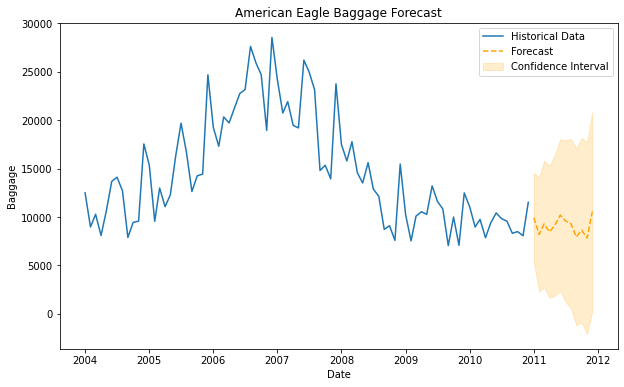


United Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -818.853
Date:                            Wed, 27 Dec 2023   AIC                           1645.706
Time:                                    22:47:51   BIC                           1655.381
Sample:                                01-01-2004   HQIC                          1649.593
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2653      0.095     -2.786      0.005      -0.452      -0.079
ar.S.L12    

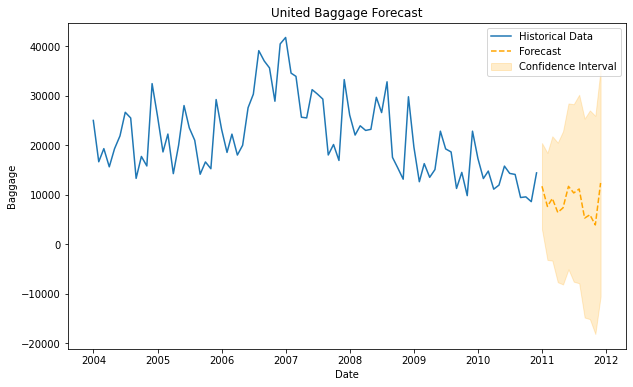


Hawaiian Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   84
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -596.230
Date:                Wed, 27 Dec 2023   AIC                           1198.460
Time:                        22:47:52   BIC                           1205.752
Sample:                    01-01-2004   HQIC                          1201.391
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    408.6858    155.960      2.620      0.009     103.009     714.362
ar.L1          0.7534      0.083      9.078      0.000       0.591       0.916
sigma2       8.58e+04   1.3

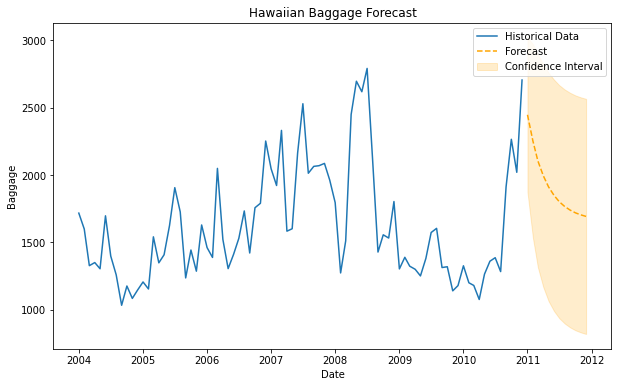

In [50]:
for airline, df in {'American Eagle': dfae, 'United': dfu, 'Hawaiian': dfh}.items():
    df.index = pd.to_datetime(df.index)

    y = df['Baggage']

    # AutoARIMA to automatically find the best ARIMA model
    model = auto_arima(y, seasonal=True, m=12)
    
    model.fit(y)

    # Model summary
    print(f"\n{airline} Model Summary:")
    print(model.summary())

    # Forecast for the next 'n_periods' periods
    n_periods = 12 
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    # DataFrame for the forecast results
    forecast_index = pd.date_range(start=y.index[-1] + pd.DateOffset(1), periods=n_periods, freq='MS')
    forecast_df = pd.DataFrame({'Forecast': forecast, 'Lower_CI': conf_int[:, 0], 'Upper_CI': conf_int[:, 1]}, index=forecast_index)
    
    print(f"\n{airline} Forecast:")
    print(forecast_df)

    # Plot 
    plt.figure(figsize=(10, 6))
    plt.plot(y, label='Historical Data')
    plt.plot(forecast_df['Forecast'], label='Forecast', linestyle='dashed', color='orange')
    plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], color='orange', alpha=0.2, label='Confidence Interval')
    plt.title(f'{airline} Baggage Forecast')
    plt.xlabel('Date')
    plt.ylabel('Baggage')
    plt.legend()
    plt.show()


We can observe that we have large confidence intervals in the ARIMA forecasts which is indicative of uncertainty or variability in the predictions. It can make sense since earlier we observed a high variability on our data and difficulty to recognise regular patterns. ARIMA models assume that future observations will follow similar patterns as historical ones, but as the underlying process is highly variable, predictions become less precise.